# Lab 8- Deep Learning Model

This lab is meant to get you started in using Keras to design Deep Neural Networks. The goal here is to simply repeat your previous lab, but with DNNs.

Let's start with reading the data, like before:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

filename="SUSY.csv"
VarNames=["signal", "l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", "l_2_phi", "MET", "MET_phi", "MET_rel", "axial_MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]
RawNames=["l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", "l_2_phi","MET", "MET_phi", "MET_rel", "axial_MET"]
FeatureNames=["M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]

df = pd.read_csv(filename, dtype='float64', names=VarNames)

Now lets define training and test samples. Note that DNNs take very long to train, so for testing purposes we will use only about 10% of the 5 million events in the training/validation sample. Once you get everything working, make the final version of your plots with the full sample. 

Also note that Keras had trouble with the Pandas tensors, so after doing all of the nice manipulation that Pandas enables, we convert the Tensor to a regular numpy tensor.

In [3]:
N_Max=550000
N_Train=500000

Train_Sample=df[:N_Train]
Test_Sample=df[N_Train:N_Max]

X_Train=np.array(Train_Sample[VarNames[1:]])
y_Train=np.array(Train_Sample["signal"])

X_Test=np.array(Test_Sample[VarNames[1:]])
y_Test=np.array(Test_Sample["signal"])


## Exercise 1

You will need to create several models and make sure they are properly trained. Write a function that takes this history and plots the values versus epoch. For every model that you train in the remainder of this lab, assess:

* Has you model's performance plateaued? If not train for more epochs. 
* Compare the performance on training versus test sample. Are you over training?

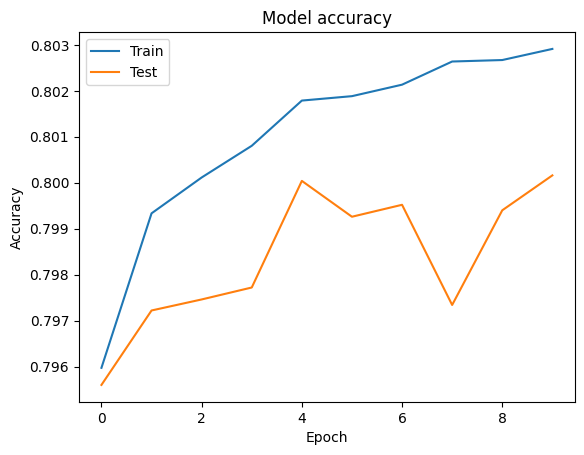

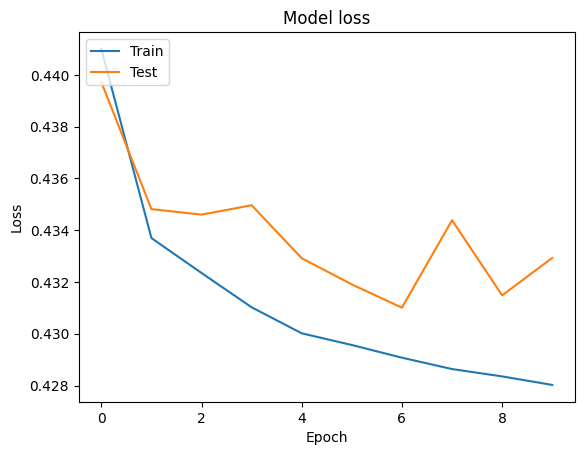

Test Accuracy: 0.8001599907875061


In [4]:

import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

def create_and_train_model(X_train, y_train, X_test, y_test, epochs=50, hidden_layer_units=(64, 32), learning_rate=0.001):
    # Create a neural network model
    model = Sequential()
    model.add(Dense(hidden_layer_units[0], input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(hidden_layer_units[1], activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32, verbose=0)

    # Plot training history
    plot_training_history(history)

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test Accuracy: {test_accuracy}')

    return model

def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# Example usage
model_history = create_and_train_model(X_Train, y_Train, X_Test, y_Test, epochs=10, hidden_layer_units=(64, 32), learning_rate=0.001)


## Exercise 2

Following the original paper (see lab 6), make a comparison of the performance (using ROC curves and AUC) between models trained with raw, features, and raw+features data.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

def create_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_and_evaluate_model(X_train, y_train, X_test, y_test):
    model = create_model(X_train.shape[1])
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    return model, history

def plot_roc_curve(model, X_test, y_test, label):
    y_pred = model.predict(X_test).ravel()
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

# Split the data into raw, features, and raw+features
X_Raw = np.array(Train_Sample[RawNames])
X_Features = np.array(Train_Sample[FeatureNames])
X_RawFeatures = np.array(Train_Sample[VarNames[1:]])

# Split the test data 
X_Test_Raw = np.array(Test_Sample[RawNames])
X_Test_Features = np.array(Test_Sample[FeatureNames])
X_Test_RawFeatures = np.array(Test_Sample[VarNames[1:]])

# Train models
model_raw, _ = train_and_evaluate_model(X_Raw, y_Train, X_Test_Raw, y_Test)
model_features, _ = train_and_evaluate_model(X_Features, y_Train, X_Test_Features, y_Test)
model_raw_features, _ = train_and_evaluate_model(X_RawFeatures, y_Train, X_Test_RawFeatures, y_Test)

# Plot ROC curves
plt.figure(figsize=(8, 6))

plot_roc_curve(model_raw, X_Test_Raw, y_Test, 'Raw Data')
plot_roc_curve(model_features, X_Test_Features, y_Test, 'Features')
plot_roc_curve(model_raw_features, X_Test_RawFeatures, y_Test, 'Raw + Features')

plt.show()


2023-12-01 21:40:42.703894: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-01 21:40:42.712391: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Exercise 3

Design and implement at least 3 different DNN models. Train them and compare performance. You may try different architectures, loss functions, and optimizers to see if there is an effect.

In [ ]:

from keras.optimizers import RMSprop
from sklearn.metrics import roc_auc_score

def create_model_1(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_model_2(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_model_3(input_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    # Evaluate on test set
    y_pred = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred)
    return history, auc

# Train and evaluate Model 1
model_1 = create_model_1(X_Train.shape[1])
history_1, auc_1 = train_and_evaluate(model_1, X_Train, y_Train, X_Test, y_Test)

# Train and evaluate Model 2
model_2 = create_model_2(X_Train.shape[1])
history_2, auc_2 = train_and_evaluate(model_2, X_Train, y_Train, X_Test, y_Test)

# Train and evaluate Model 3
model_3 = create_model_3(X_Train.shape[1])
history_3, auc_3 = train_and_evaluate(model_3, X_Train, y_Train, X_Test, y_Test)

# Compare performance
print(f'Model 1 AUC: {auc_1:.4f}')
print(f'Model 2 AUC: {auc_2:.4f}')
print(f'Model 3 AUC: {auc_3:.4f}')

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_1.history['accuracy'], label='Model 1')
plt.plot(history_2.history['accuracy'], label='Model 2')
plt.plot(history_3.history['accuracy'], label='Model 3')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_1.history['val_loss'], label='Model 1')
plt.plot(history_2.history['val_loss'], label='Model 2')
plt.plot(history_3.history['val_loss'], label='Model 3')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Exercise 4

Repeat exercise 4 from Lab 7, adding your best performing DNN as one of the models.  


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, accuracy_score

def preprocess_data(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

def polynomial_regression(X_train, y_train, X_test, degree=2):
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    return model, X_test_poly

def get_classifiers():
    classifier_1 = LogisticRegression(random_state=42)
    classifier_2 = LinearRegression()
    classifier_3 = SVC(probability=True, random_state=42)
    return classifier_1, classifier_2, classifier_3

def compare_classifiers(classifiers, X_train, y_train, X_test, y_test):
    plt.figure(figsize=(10, 6))

    for classifier in classifiers:
        classifier_name = classifier.__class__.__name__
        print(f"Training {classifier_name}...")


        X_train_scaled, X_test_scaled = preprocess_data(X_train, X_test)

        if classifier_name == 'LinearRegression':
            model, X_test_poly = polynomial_regression(X_train_scaled, y_train, X_test_scaled, degree=2)
            y_pred = model.predict(X_test_poly)
        else:
            
            classifier.fit(X_train_scaled, y_train)
            
            y_pred = classifier.predict_proba(X_test_scaled)[:, 1]

        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{classifier_name} (AUC = {roc_auc:.2f})')

    plt.title('Classifier Comparison')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()


def compute_maximal_significance(classifier, X_train, y_train, X_test, y_test):
    
    X_train_scaled, X_test_scaled = preprocess_data(X_train, X_test)

    if isinstance(classifier, LinearRegression):
        model, X_test_poly = polynomial_regression(X_train_scaled, y_train, X_test_scaled, degree=2)
        y_pred = model.predict(X_test_poly)
    else:
        
        classifier.fit(X_train_scaled, y_train)
        
        y_pred = classifier.predict_proba(X_test_scaled)[:, 1]

   
    signal_events = X_test[y_test == 1]  # assuming y_test == 1 represents signal events
    background_events = X_test[y_test == 0]  # assuming y_test == 0 represents background events
    significance = some_significance_function(signal_events, background_events, y_pred[y_test == 1])

    print(f'Maximal Significance: {significance:.4f}')

#Example usage
classifiers = get_classifiers()
compare_classifiers(classifiers, X_Train, y_Train, X_Test, y_Test)


best_classifier = classifiers[0]  # Adjust this based on the results of the comparison

# Use the best classifier to compute maximal significance
compute_maximal_significance(best_classifier, X_Train, y_Train, X_Test, y_Test)
